# Agenda 
1. General Data Properties
2. Access the quality of the data
    1. Checking incorrect value types
    2. Missing values and empty data & incorrect or invalid values
    3. Outliers and non relevant data
3. Data Wrangling & Analysis

## 1. General Data Properties

In [114]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [115]:
# Read in the given data and set the index column to the date column and parse the dates
df=pd.read_csv("../01_data_source/sickness_table.csv", index_col="date", parse_dates=True ) 
df.index.freq="D" #Set the frequence to Daily
df.index

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10',
               ...
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27'],
              dtype='datetime64[ns]', name='date', length=1152, freq='D')

In [116]:
df.head()

,Unnamed: 0,n_sick,calls,n_duty,n_sby,sby_need,dafted
date,,,,,,,
2016-04-01,0,73,8154.0,1700,90,4.0,0.0
2016-04-02,1,64,8526.0,1700,90,70.0,0.0
2016-04-03,2,68,8088.0,1700,90,0.0,0.0
2016-04-04,3,71,7044.0,1700,90,0.0,0.0
2016-04-05,4,63,7236.0,1700,90,0.0,0.0


In [117]:
df.describe()

,Unnamed: 0,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
mean,575.500000,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,332.698061,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,0.000000,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,287.750000,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,575.500000,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,863.250000,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000
max,1151.000000,119.000000,11850.000000,1900.000000,90.0,555.000000,465.000000


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Freq: D
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   n_sick      1152 non-null   int64  
 2   calls       1152 non-null   float64
 3   n_duty      1152 non-null   int64  
 4   n_sby       1152 non-null   int64  
 5   sby_need    1152 non-null   float64
 6   dafted      1152 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 72.0 KB


### 1.1 Columns descriptions
- date: entry date
- n_sick: number of drivers called sick on duty
- calls: number of emergency call
- n_duty: number of drivers on duty available
- n_sby: number of standby resources available
- sby_need: number of standbys, which are activated on a given day
- dafted: number of additional drivers needed due to not enough standbys

### 1.2 Additional informations
- Business claims, that having a daily fixed amount of standbys (n_sby = 90) is not efficient because there  are days with too many standbys followed by days with not enough standbys. The business aims at a more dynamical standby allocation, which takes seasonal patterns into account.
- Most important, the model should minimize dates with not enough standby drivers at hand!

## 2. Access the quality of the data

- Missing values and empty data
- Data imputation 
- Incorrect types 
- incorrect or invalid values
- outliers and non relevant data
- statistical sanitization

### A: Checking incorrect value types

In [119]:
# What kind of variable types are given in the data frame
df.dtypes

Unnamed: 0      int64
n_sick          int64
calls         float64
n_duty          int64
n_sby           int64
sby_need      float64
dafted        float64
dtype: object

It seems reaonable, that the number of sick drivers (n_sick), the drivers on duty (n_duty), number of standby resources available (n_sby) are integer values since there are no half drivers. The columns calls, standby drivers needed (sby_need) as well as the column dafter (number of additional drivers needed due to not enough standbys) are float values. In this use case no float values are needed. The float values will be transformed to int64:

In [120]:
df["calls"] = df["calls"].apply(np.int64)
df["sby_need"] = df["sby_need"].apply(np.int64)
df["dafted"] = df["dafted"].apply(np.int64)

In [121]:
df.dtypes

Unnamed: 0    int64
n_sick        int64
calls         int64
n_duty        int64
n_sby         int64
sby_need      int64
dafted        int64
dtype: object

In [122]:
# How much data lines includes the dataframe
print( f"The dataframe contains: {len(df)} datasets. One dataset is one day resulting in data for roundabout {len(df)/365} years")

The dataframe contains: 1152 datasets. One dataset is one day resulting in data for roundabout 3.1561643835616437 years


### B: Missing values and empty data & incorrect or invalid values

In [123]:
# Are values values missing:
df.isnull().sum()

Unnamed: 0    0
n_sick        0
calls         0
n_duty        0
n_sby         0
sby_need      0
dafted        0
dtype: int64

As displayed there are no missing values. And we have seen above all columns contain only integer value thus the values are valid. Thus no data imputation is needed


### C: Outliers and non relevant data

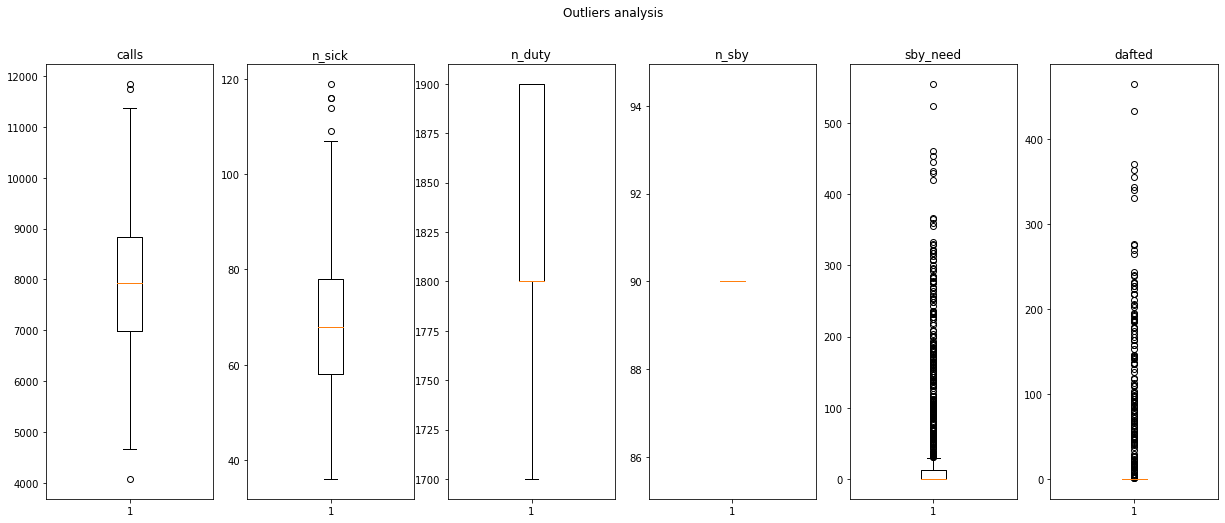

In [124]:
fig, (fig1, fig2, fig3, fig4, fig5, fig6) = plt.subplots(1, 6)
fig.suptitle('Outliers analysis')
fig.set_figheight(8)
fig.set_figwidth(21)
fig1.boxplot(df["calls" ])
fig1.set_title('calls')
fig2.boxplot(df["n_sick"])
fig2.set_title('n_sick')
fig3.boxplot(df["n_duty"])
fig3.set_title('n_duty')
fig4.boxplot(df["n_sby"])
fig4.set_title('n_sby')
fig5.boxplot(df["sby_need"])
fig5.set_title('sby_need')
fig6.boxplot(df["dafted"])
fig6.set_title('dafted');

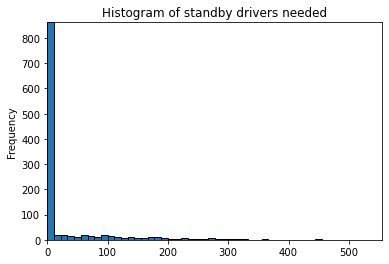

In [125]:
df["sby_need"].plot.hist(bins=50,edgecolor="k", title="Histogram of standby drivers needed").autoscale(enable=True,axis="both", tight=True)

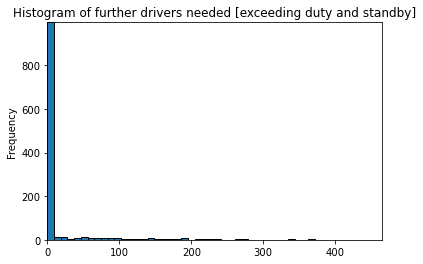

In [126]:
df["dafted"].plot.hist(bins=50,edgecolor="k", title="Histogram of further drivers needed [exceeding duty and standby]").autoscale(enable=True,axis="both", tight=True)

Column "calls":
- The columns calls has two small outliers around 11800.This seems to me reasonable 

Column "n_sick": 
- The column n_sick has 4 outliers around 110-120. This seems to me reasonable as well 

Column "n_duty":
- no major outliers can be detected

column "n_sby":
- its a fixed number --> no outliers

columns sby_need & dafted: 
- The column sby_need describes the number of standbys activated on a given day. The column "dafted" describes the number of additional drivers needed due to not enough standbys. These values are equal zero when enough drivers are on duty and no additional drivers are needed. This is the case for the most times (see Histogram). In some cases the number of drivers on duty is not sufficient and thus sby_needed is greater then 0 and if this number exeeds 90 the number duafted is greater then 0 as well. 
- The boxplots diagrams show a lot of outliers here. This is reasonable since just in a few cases standby drivers are needed as well as dafted drivers. 

###### All together no unreasonable outliers are detected in the dataset

## 3. Data Wrangling & Analysis

### Data Wrangling
- Reshaping and transforming structures
- Indexing data for quick access (already done in chapter one)
- Merging, combining and joining data

### Analysis
- Exploration 
- Visualization and representation 
- Correlation vs Causation analysis
- Statistical analysis

### A: Merging, combining and joining data
- the column of the number of drivers working at the given date is not calculated yet 
- drivers_atwork= n_duty + sby_need

In [127]:
df["drivers_atwork"]=df["n_duty"]+df["sby_need"]


### B: Visaulization and representation

#### Basic visualization

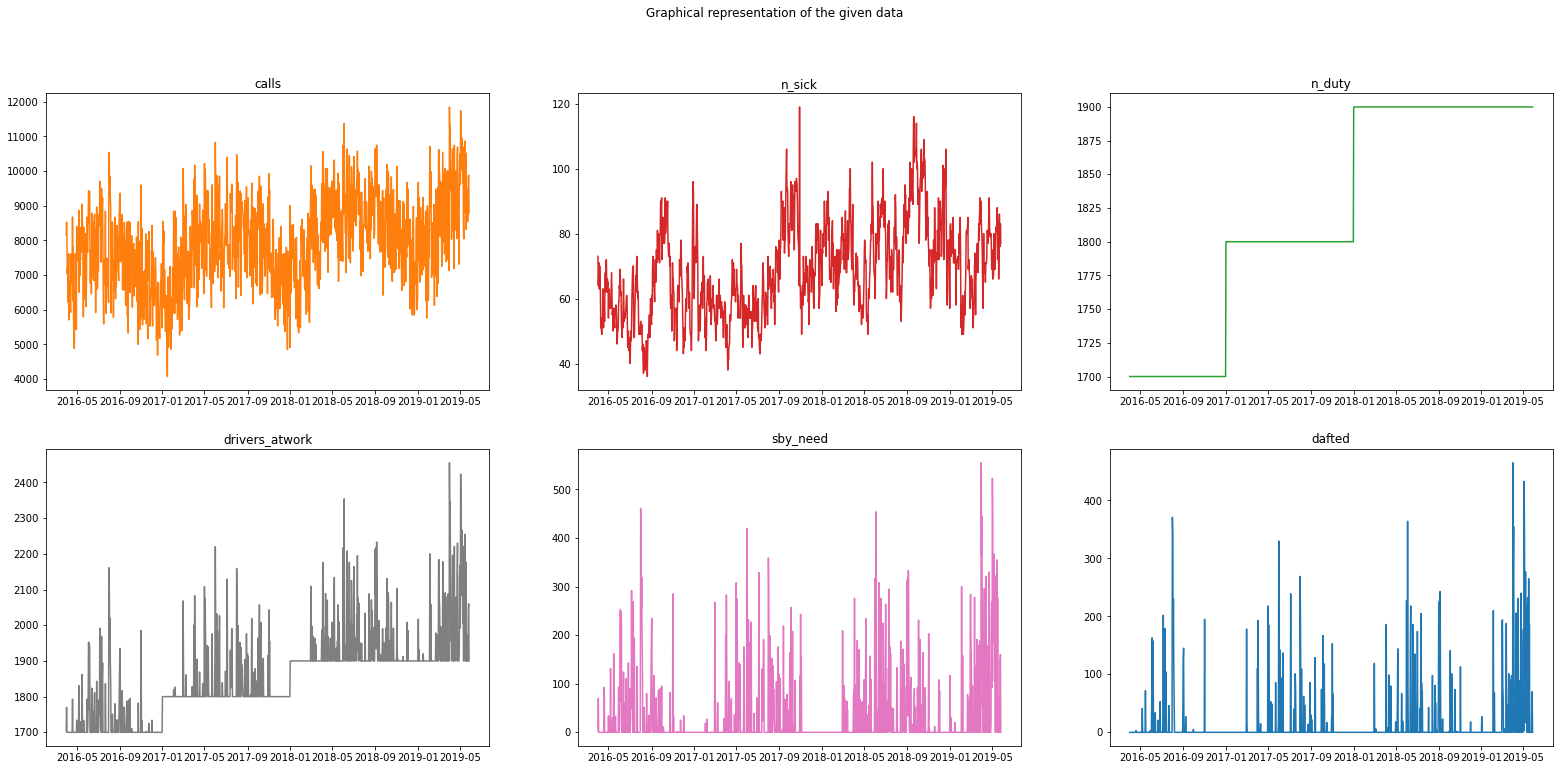

In [128]:
fig, ((fig1, fig2, fig3), (fig4, fig5, fig6))= plt.subplots(2, 3)
fig.suptitle('Graphical representation of the given data')
fig.set_figheight(12)
fig.set_figwidth(27)
fig1.plot(df["calls" ], "tab:orange")
fig1.set_title('calls')
fig2.plot(df["n_sick"], "tab:red")
fig2.set_title('n_sick')
fig3.plot(df["n_duty"], "tab:green")
fig3.set_title('n_duty')
fig4.plot(df["drivers_atwork"], "tab:grey")
fig4.set_title('drivers_atwork')
fig5.plot(df["sby_need"], "tab:pink")
fig5.set_title('sby_need')
fig6.plot(df["dafted"], "tab:blue")
fig6.set_title('dafted');

#n_sby is not considered here since its a fixed value and thus boring

Column "calls":
- the calls seems to have a trend (more calls with increasing times) as well as a seasonal (seasonal fluctuation) component  - there is definitely some noice in the data 
- Analysis of trend and sesonality is needed! 

Column "n_sick":
- the calls seems to have a weak trend (more calls with increasing times) as well as a weak seasonal (seasonal fluctuation) component --> closer look is necessary
- Analysis of trend and sesonality is needed! 

Column "n_duty":
- the number of planned duty drivers is jump-fixed

column "drivers_atwork":
- the buttom line is the number of drivers on duty
- besides the base line, there are days where more drivers needs to be at work
- the pattern of days where more drivers has to be at work seems to be seasonal --> closer look is needed 
- it seems that the amount of drivers at work is correlating with the number of calls --> closer look is needed

columns sby_need & dafted:
- base line is 0 
- sby_need and dafted are connected --> max(sby_need-n_sby;0)
- The peaks of the data seems to be seasonal

#### Analyzing Trends & Seasonalities

Calls, n_sick & drivers_atwork seems to have a seasonal and a trend component. Further evaluation are conducted in the following.

In [129]:
def test_adfuller(series,title=''):
    """
    A Augmented Dickey-Fuller Test-Report is created based on the given time series and an optional title
    """
    print(f'DF-Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())   
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject of the null hypothesis")
        print("Data is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

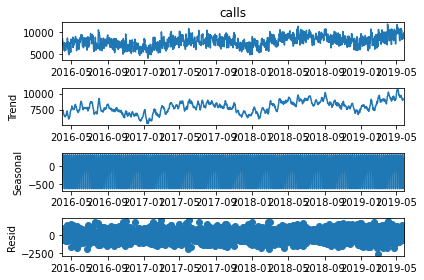

In [130]:
#calls
results=seasonal_decompose(df["calls"], model="add")
results.plot();

In [131]:
results.seasonal.head(59)

date
2016-04-01    -34.035301
2016-04-02   -212.149504
2016-04-03   -637.308136
2016-04-04    312.846232
2016-04-05    299.685953
2016-04-06    201.328810
2016-04-07     69.631946
2016-04-08    -34.035301
2016-04-09   -212.149504
2016-04-10   -637.308136
2016-04-11    312.846232
2016-04-12    299.685953
2016-04-13    201.328810
2016-04-14     69.631946
2016-04-15    -34.035301
2016-04-16   -212.149504
2016-04-17   -637.308136
2016-04-18    312.846232
2016-04-19    299.685953
2016-04-20    201.328810
2016-04-21     69.631946
2016-04-22    -34.035301
2016-04-23   -212.149504
2016-04-24   -637.308136
2016-04-25    312.846232
2016-04-26    299.685953
2016-04-27    201.328810
2016-04-28     69.631946
2016-04-29    -34.035301
2016-04-30   -212.149504
2016-05-01   -637.308136
2016-05-02    312.846232
2016-05-03    299.685953
2016-05-04    201.328810
2016-05-05     69.631946
2016-05-06    -34.035301
2016-05-07   -212.149504
2016-05-08   -637.308136
2016-05-09    312.846232
2016-05-10    299.68

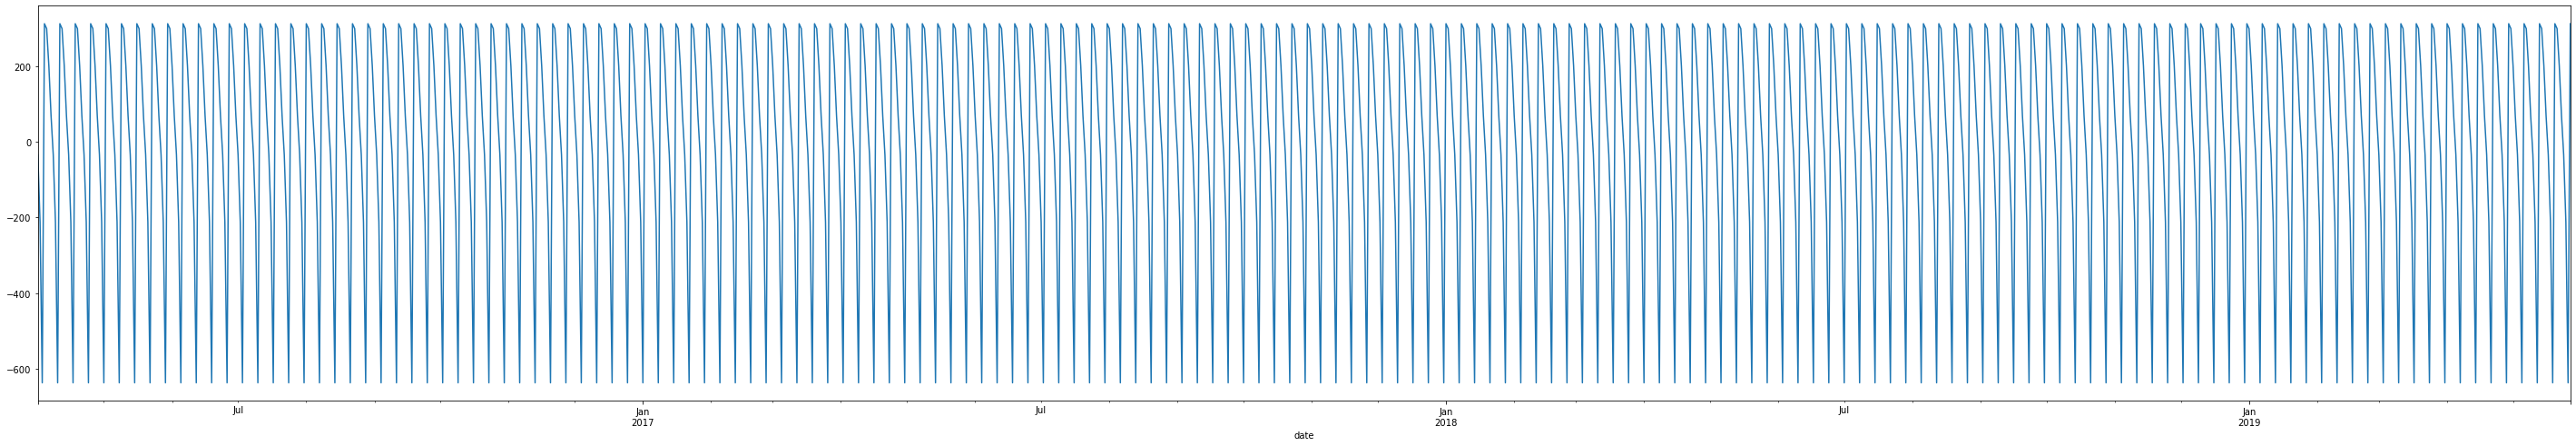

In [132]:
results.seasonal.plot(figsize=(50,8));

In [133]:
test_adfuller(df["calls"], "ADF Test for calls on a daily basis")

DF-Test: ADF Test for calls on a daily basis
ADF test statistic        -2.761936
p-value                    0.063920
# lags used               19.000000
# observations          1132.000000
critical value (1%)       -3.436140
critical value (5%)       -2.864097
critical value (10%)      -2.568131
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


In [134]:
calls_m =df["calls"].resample(rule="MS").mean()

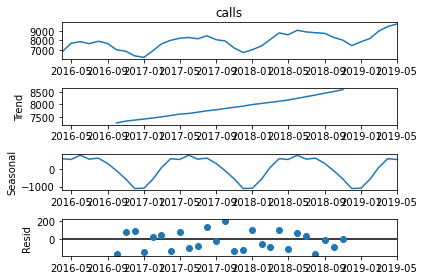

In [135]:
results=seasonal_decompose(calls_m, model="add")
results.plot();

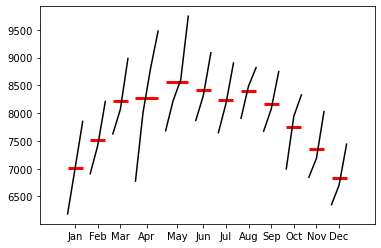

In [136]:
month_plot(calls_m);

In [137]:
test_adfuller(calls_m, "ADF Test for calls on a month basis")

DF-Test: ADF Test for calls on a month basis
ADF test statistic       0.399761
p-value                  0.981486
# lags used             10.000000
# observations          27.000000
critical value (1%)     -3.699608
critical value (5%)     -2.976430
critical value (10%)    -2.627601
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


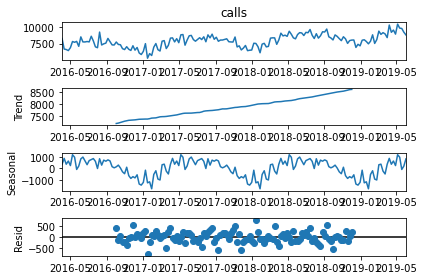

In [138]:
calls_w =df["calls"].resample(rule="W").mean()
results=seasonal_decompose(calls_w, model="add")
results.plot();

In [139]:
test_adfuller(calls_w, "ADF Test for calls on a weekly basis")

DF-Test: ADF Test for calls on a weekly basis
ADF test statistic       -2.811003
p-value                   0.056719
# lags used              10.000000
# observations          155.000000
critical value (1%)      -3.473259
critical value (5%)      -2.880374
critical value (10%)     -2.576812
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


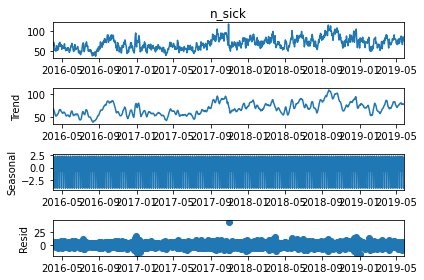

In [140]:
# n_sick
results=seasonal_decompose(df["n_sick"], model="add")
results.plot();

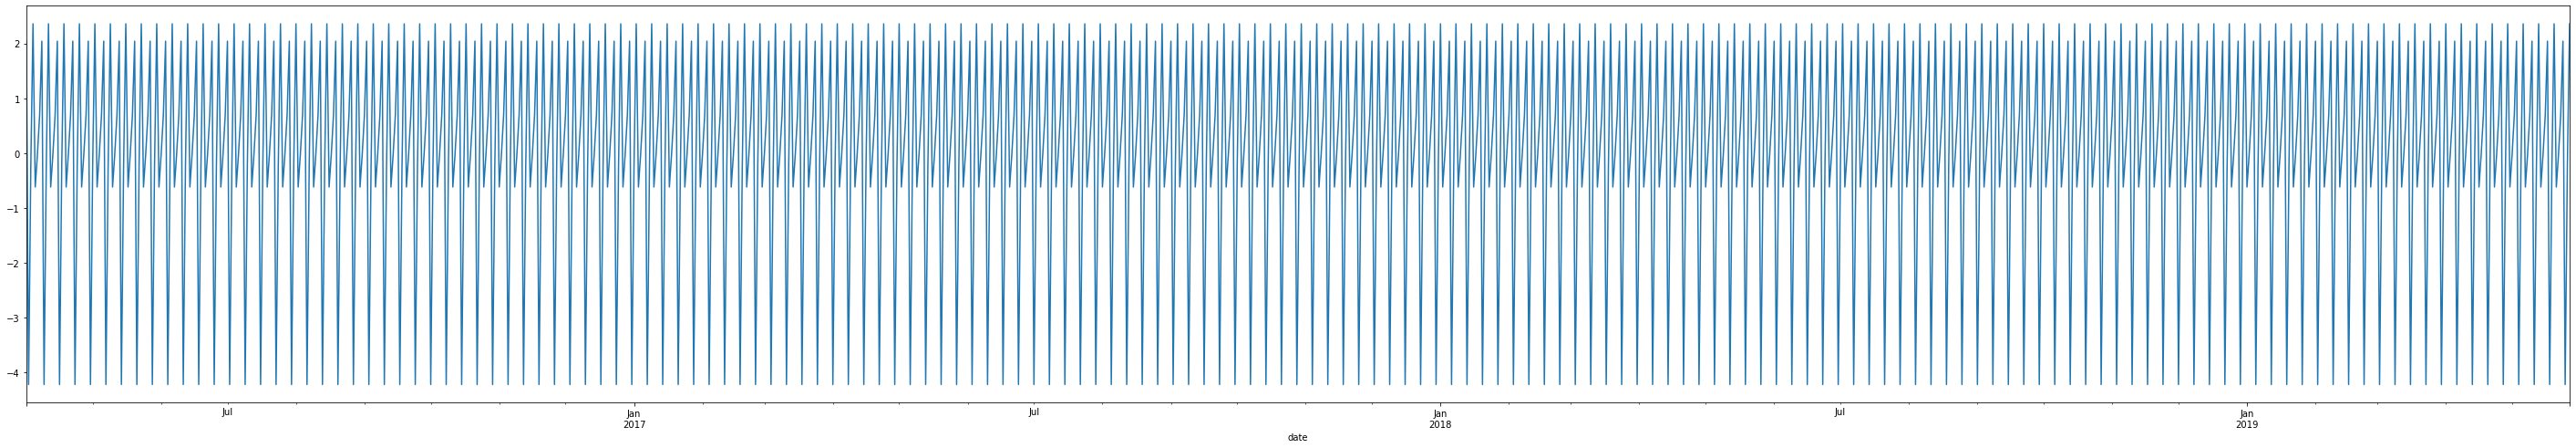

In [141]:
results.seasonal.plot(figsize=(50,8));

In [142]:
test_adfuller(df["n_sick"], "ADF Test for n_sick on a daily basis")

DF-Test: ADF Test for n_sick on a daily basis
ADF test statistic        -3.374317
p-value                    0.011866
# lags used               21.000000
# observations          1130.000000
critical value (1%)       -3.436150
critical value (5%)       -2.864101
critical value (10%)      -2.568134
Strong evidence against the null hypothesis
Reject of the null hypothesis
Data is stationary


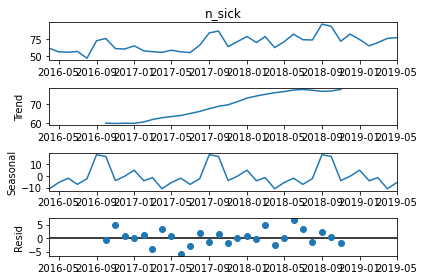

In [143]:
n_sick_m =df["n_sick"].resample(rule="MS").mean()
results=seasonal_decompose(n_sick_m, model="add")
results.plot();

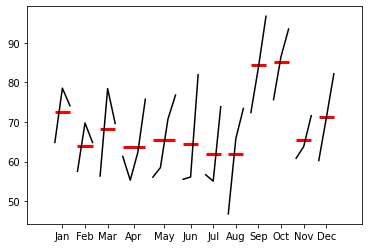

In [144]:
month_plot(n_sick_m);

In [145]:
test_adfuller(n_sick_m, "ADF Test for n_sick on a monthly basis")

DF-Test: ADF Test for n_sick on a monthly basis
ADF test statistic      -1.795900
p-value                  0.382499
# lags used              2.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


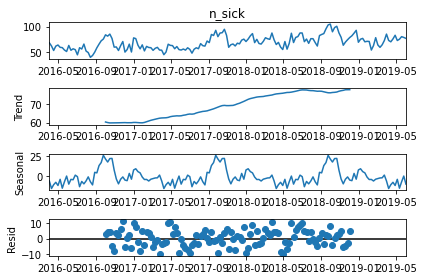

In [146]:
n_sick_w =df["n_sick"].resample(rule="W").mean()
results=seasonal_decompose(n_sick_w, model="add")
results.plot();

In [147]:
test_adfuller(n_sick_w, "ADF Test for n_sick on a weekly basis")

DF-Test: ADF Test for n_sick on a weekly basis
ADF test statistic       -3.796061
p-value                   0.002948
# lags used               1.000000
# observations          164.000000
critical value (1%)      -3.470866
critical value (5%)      -2.879330
critical value (10%)     -2.576255
Strong evidence against the null hypothesis
Reject of the null hypothesis
Data is stationary


In [148]:
#drivers_atwork

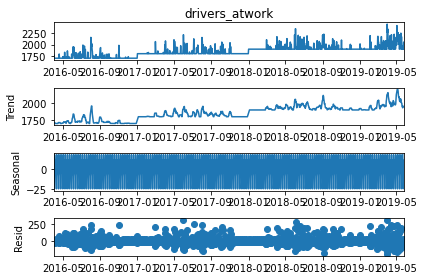

In [149]:
results=seasonal_decompose(df["drivers_atwork"], model="add")
results.plot();

<AxesSubplot:xlabel='date'>

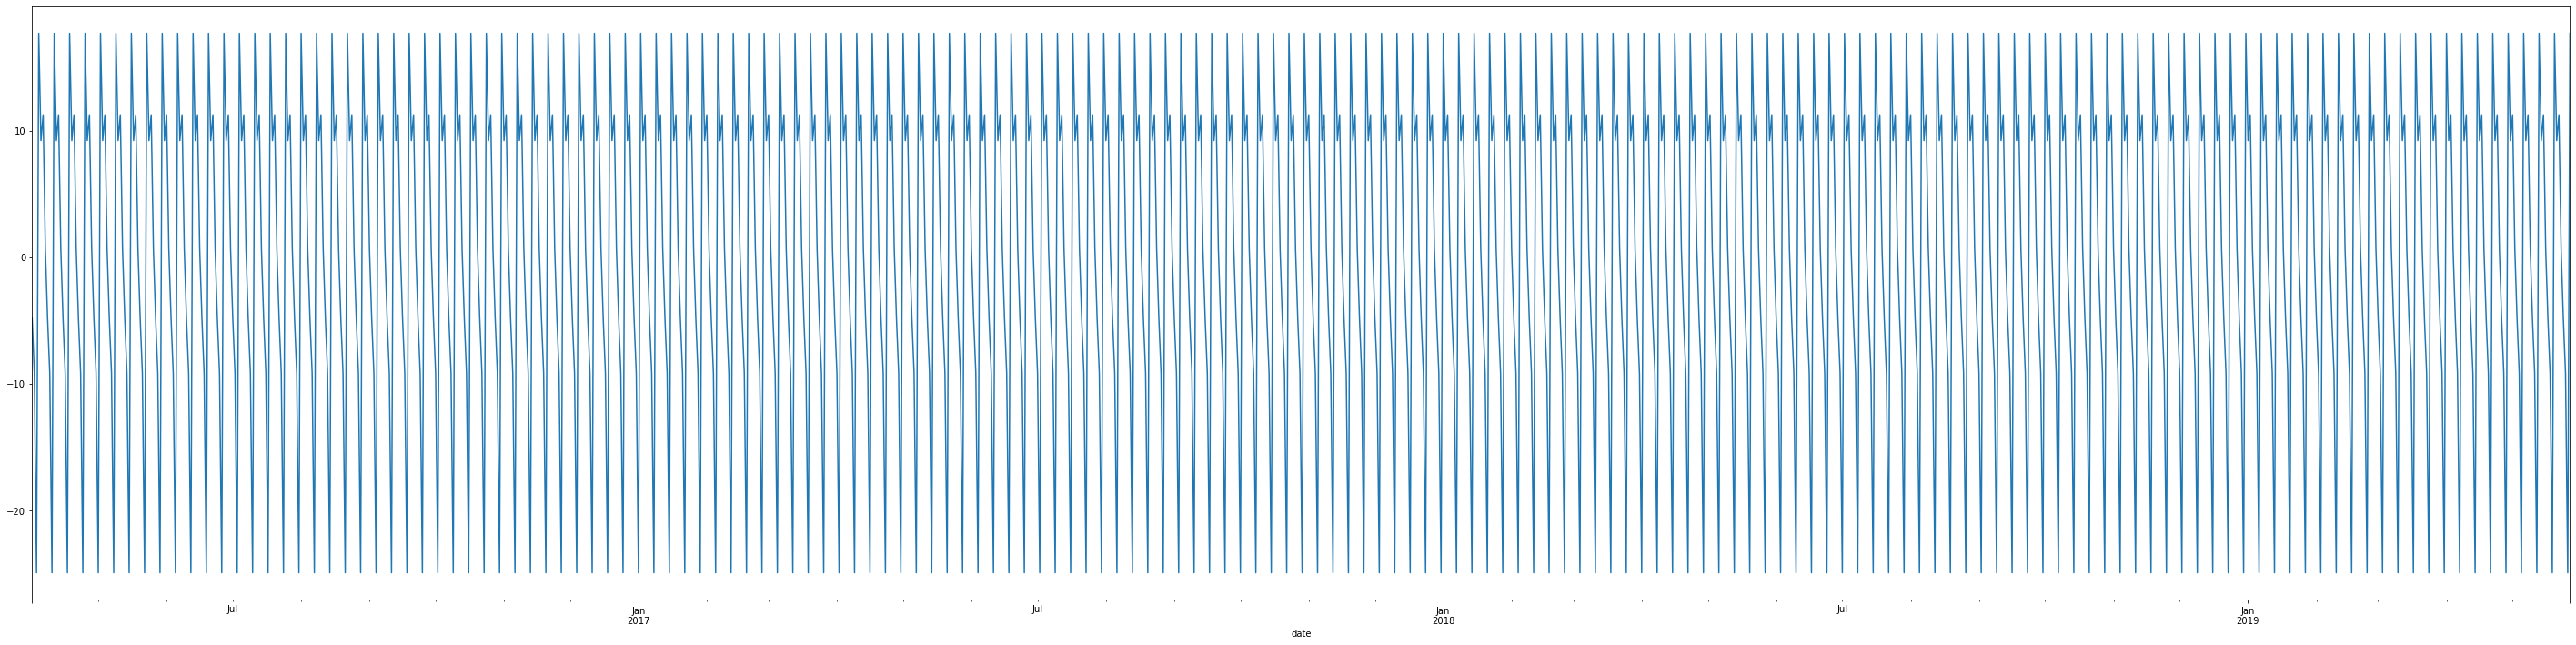

In [150]:
results.seasonal.plot(figsize=(50,12))

In [151]:
test_adfuller(df["drivers_atwork"], "ADF Test for drivers_atwork on a daily basis")

DF-Test: ADF Test for drivers_atwork on a daily basis
ADF test statistic        -1.843787
p-value                    0.358949
# lags used               21.000000
# observations          1130.000000
critical value (1%)       -3.436150
critical value (5%)       -2.864101
critical value (10%)      -2.568134
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


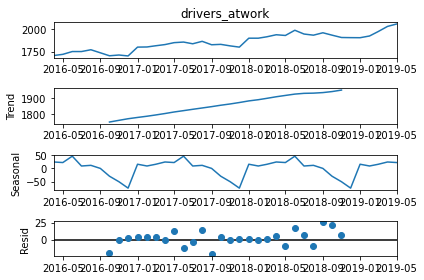

In [152]:
drivers_atwork_m=df["drivers_atwork"].resample(rule="MS").mean()
results=seasonal_decompose(drivers_atwork_m, model="add")
results.plot();

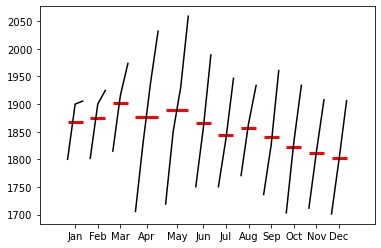

In [153]:
month_plot(drivers_atwork_m);

In [154]:
test_adfuller(drivers_atwork_m, "ADF Test for drivers_atwork on a monthly basis")

DF-Test: ADF Test for drivers_atwork on a monthly basis
ADF test statistic      -0.556377
p-value                  0.880538
# lags used             10.000000
# observations          27.000000
critical value (1%)     -3.699608
critical value (5%)     -2.976430
critical value (10%)    -2.627601
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


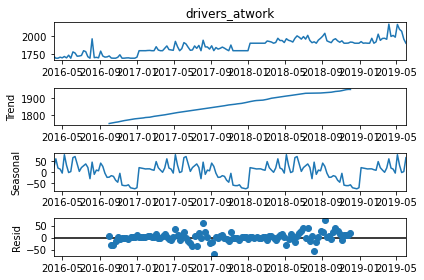

In [155]:
drivers_atwork_w=df["drivers_atwork"].resample(rule="W").mean()
results=seasonal_decompose(drivers_atwork_w, model="add")
results.plot();

In [156]:
test_adfuller(drivers_atwork_w, "ADF Test for drivers_atwork on a weekly basis")

DF-Test: ADF Test for drivers_atwork on a weekly basis
ADF test statistic       -1.183565
p-value                   0.680626
# lags used               4.000000
# observations          161.000000
critical value (1%)      -3.471633
critical value (5%)      -2.879665
critical value (10%)     -2.576434
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


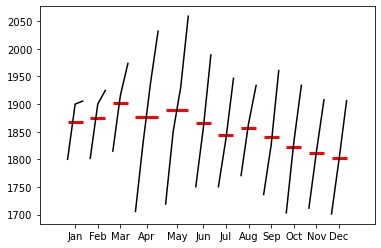

In [157]:
month_plot(drivers_atwork_m);

#### Correlation and Causation analysis

In [158]:
df_calls_driveratwork=df[["calls", "drivers_atwork"]]

In [159]:
df_calls_driveratwork.corr(method='pearson')

,calls,drivers_atwork
calls,1.000000,0.704728
drivers_atwork,0.704728,1.000000


In [160]:
#adjust the dataframe by the values where the base line is hit
df_adjusted = df.loc[df["drivers_atwork"] != 1770.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1700.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1800.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1900.0]
df_adjusted.head()

,Unnamed: 0,n_sick,calls,n_duty,n_sby,sby_need,dafted,drivers_atwork
date,,,,,,,,
2016-04-01,0,73,8154,1700,90,4,0,1704
2016-04-19,18,57,8676,1700,90,93,3,1793
2016-05-01,30,54,8400,1700,90,34,0,1734
2016-05-04,33,58,8340,1700,90,26,0,1726
2016-05-07,36,57,8868,1700,90,131,41,1831


Min_MSEError 196.22728826407905
Best linear_coef value:  4.822822822822823


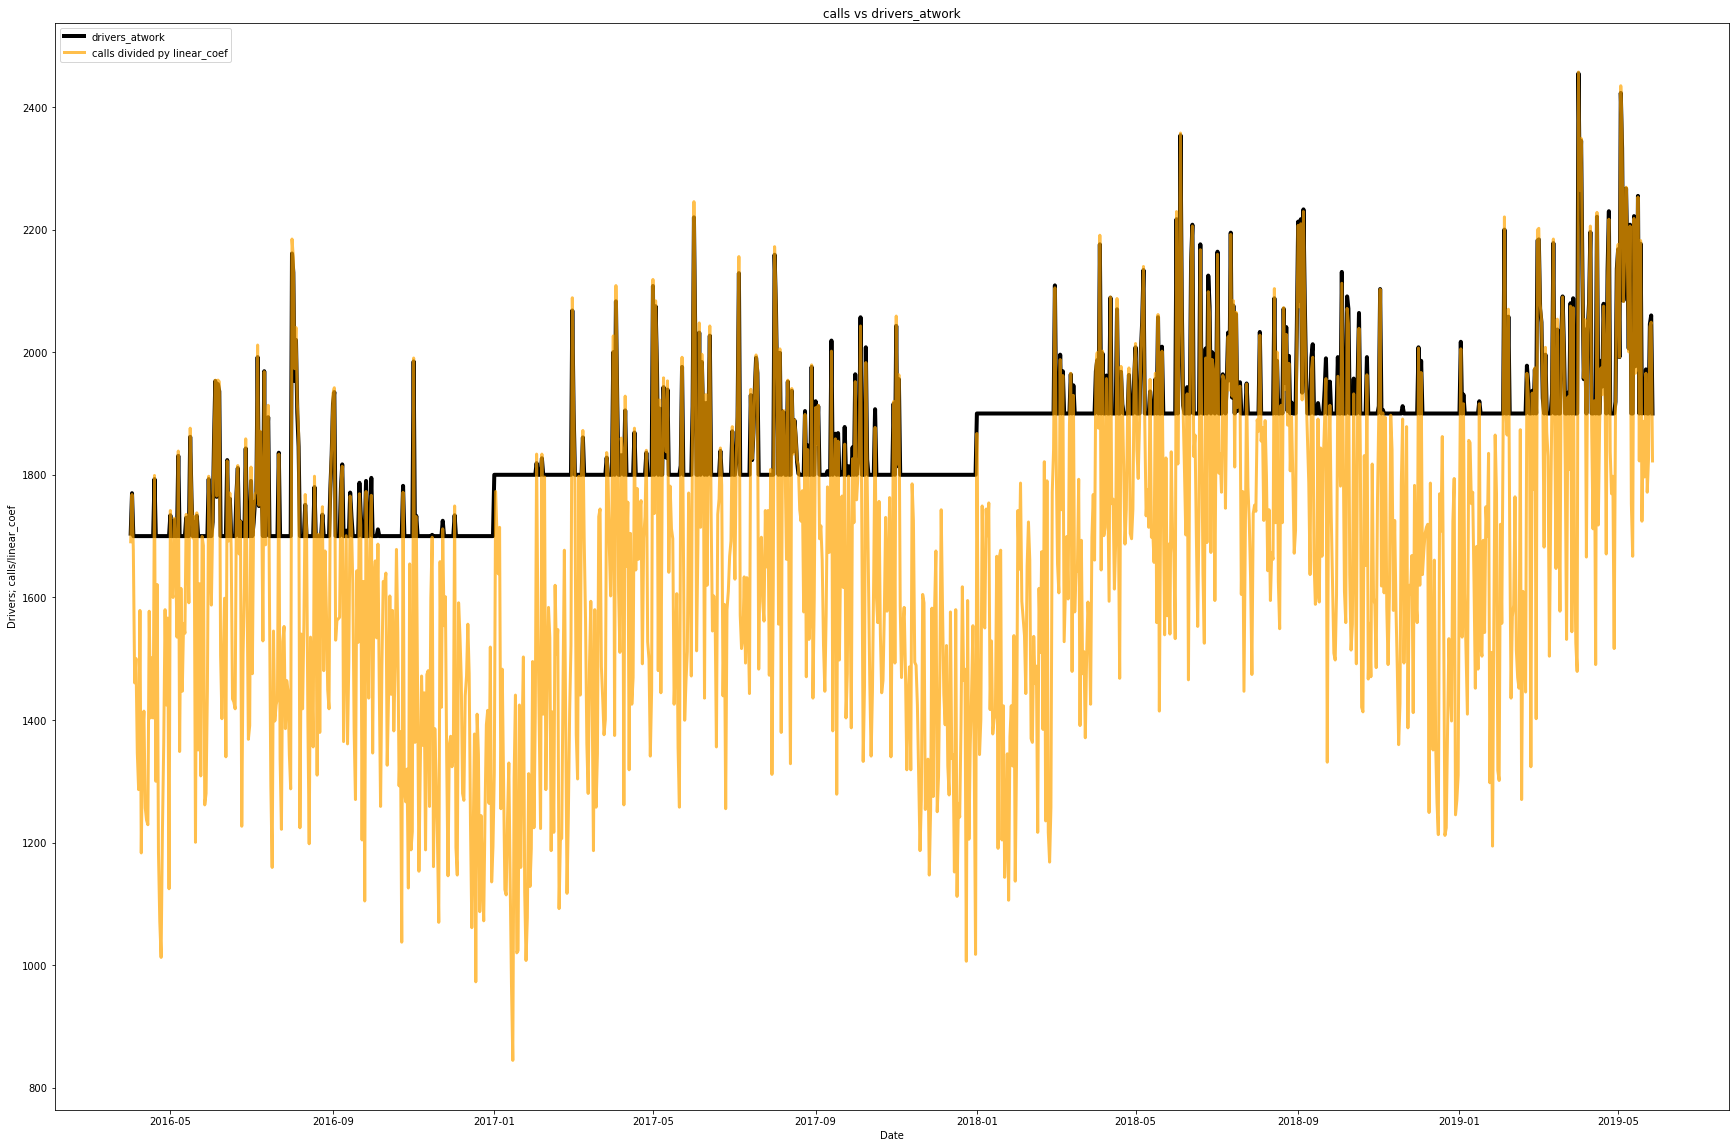

In [161]:
Min_MSEError=10**1000
x_Value=0
for x in np.linspace(2, 6, num=1000):
    ErrorSUM=0
    #print(x)
    for counter1 in range(0,len(df_adjusted)):
        a=float(df_adjusted.iloc[counter1, 7]) # drivers_atwork
        b=float(df_adjusted.iloc[counter1, 2]) # calls
        ErrorSUM=ErrorSUM + (a-(b/x))**2
    if Min_MSEError > (ErrorSUM/len(df_adjusted)):
        Min_MSEError=ErrorSUM/len(df_adjusted)
        x_Value=x
        
print ("Min_MSEError", Min_MSEError)
print("Best linear_coef value: ", x_Value)


fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
ax.set_title('calls vs drivers_atwork')
plt.plot(df["drivers_atwork"],color='black',label='drivers_atwork', lw=4)
plt.plot(df["calls"]/x_Value,color='orange',label="calls divided py linear_coef", alpha=0.7, lw=3)
ax.set_xlabel('Date')
ax.set_ylabel('Drivers; calls/linear_coef')
ax.legend(loc='upper left')
plt.show()

#plt.figure(figsize=(30,30))
#labels=["drivers_atwork","calls divided py linear_coef"]
#plt.plot(df["drivers_atwork"], label="drivers_atwork")
#plt.plot(df["calls"]/x_Value, label="calls divided py linear_coef")
#plt.legend()
#plt.show()

(array([88., 76., 43., 33., 29., 20.,  4.,  3.,  3.,  2.]),
 array([  2. ,  57.3, 112.6, 167.9, 223.2, 278.5, 333.8, 389.1, 444.4,
        499.7, 555. ]),
 <BarContainer object of 10 artists>)

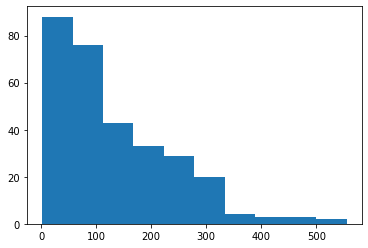

In [162]:
plt.hist(df_adjusted["sby_need"])

## Calculating the base line success KPIs to compare the model with status quo

- Percentage of standbys being activated is higher than in the current approach of keeping 90 drivers on hold
- Situations with not enough standbys should occur less often than in the current approach.

#### A: Whole dataset

In [163]:
# Percentage of standbys being activated is higher than in the current approach of keeping 90 drivers on hold
df["sby_activated"]=df["sby_need"]-df["dafted"]
df["percentage_sby_activated"]=df["sby_activated"]/df["n_sby"]
percentage_standby_activated=df["percentage_sby_activated"].mean()
print(f'{np.round(percentage_standby_activated*100,2)} % of the standby drivers are activated over the whole dataset before optimisation')

20.43 % of the standby drivers are activated over the whole dataset before optimisation


In [164]:
# Situations with not enough standbys should occur less often than in the current approach.
print(f'In {np.round(len(df[df["sby_need"]>90])/len(df)*100,2)} % of the days the amount of 90 standby drivers were exceeded')

In 14.84 % of the days the amount of 90 standby drivers were exceeded


#### B: The last 365 to compare with test data set

In [165]:
# Percentage of standbys being activated is higher than in the current approach of keeping 90 drivers on hold
df["sby_activated"]=df["sby_need"]-df["dafted"]
df["percentage_sby_activated"]=df["sby_activated"]/df["n_sby"]
percentage_standby_activated=df["percentage_sby_activated"].iloc[len(df)-365:].mean()
print(f'{np.round(percentage_standby_activated*100,2)} % of the standby drivers are activated over the whole dataset before optimisation')

28.61 % of the standby drivers are activated over the whole dataset before optimisation


In [166]:
df["datfted_for_calc"]=df["dafted"].apply(lambda x:x if x>0 else np.nan)
print(f'In {np.round(df["datfted_for_calc"].iloc[len(df)-365:].count()/365*100,2)} % of the days the amount of 90 standby drivers were exceeded')

In 22.47 % of the days the amount of 90 standby drivers were exceeded


In [167]:
df.head()

,Unnamed: 0,n_sick,calls,n_duty,n_sby,sby_need,dafted,drivers_atwork,sby_activated,percentage_sby_activated,datfted_for_calc
date,,,,,,,,,,,
2016-04-01,0,73,8154,1700,90,4,0,1704,4,0.044444,NaN
2016-04-02,1,64,8526,1700,90,70,0,1770,70,0.777778,NaN
2016-04-03,2,68,8088,1700,90,0,0,1700,0,0.000000,NaN
2016-04-04,3,71,7044,1700,90,0,0,1700,0,0.000000,NaN
2016-04-05,4,63,7236,1700,90,0,0,1700,0,0.000000,NaN


##### C: Calculating the consumed FTE (full time equivilant) shifts as a third comparison parameter (not the leading indicator ... but never the less interesting) 

In [168]:
print(f'In the last 365 days {df["n_duty"].iloc[len(df)-365:].sum() + df["sby_need"].iloc[len(df)-365:].sum()} FTE shifts were needed')
print(f'In the last 365 days {df["n_sby"].iloc[len(df)-365:].sum() - df["sby_activated"].iloc[len(df)-365:].sum()} FTE shifts were hold on standby and were not needed')

In the last 365 days 713377 FTE shifts were needed
In the last 365 days 23451 FTE shifts were hold on standby and were not needed


In [169]:
np.round(df["datfted_for_calc"].iloc[len(df)-365:].count(),2)

82